In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import datetime
import tensorboard
import cv2
import pandas as pd
import tqdm
import pickle

from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorboard.plugins import projector

In [2]:
# Training dataaset
trn_root_dir = 'Birds-Dataset/Train'
trn_dirs = [os.path.join(trn_root_dir, bird_name)
            for bird_name in os.listdir(trn_root_dir)]
trn_fnames = [os.listdir(bird_dir) for bird_dir in trn_dirs]

vldn_root_dir = 'Birds-Dataset/Validation'
vldn_dirs = [os.path.join(vldn_root_dir, bird_name)
             for bird_name in os.listdir(vldn_root_dir)]
vldn_fnames = [os.listdir(bird_dir) for bird_dir in vldn_dirs]

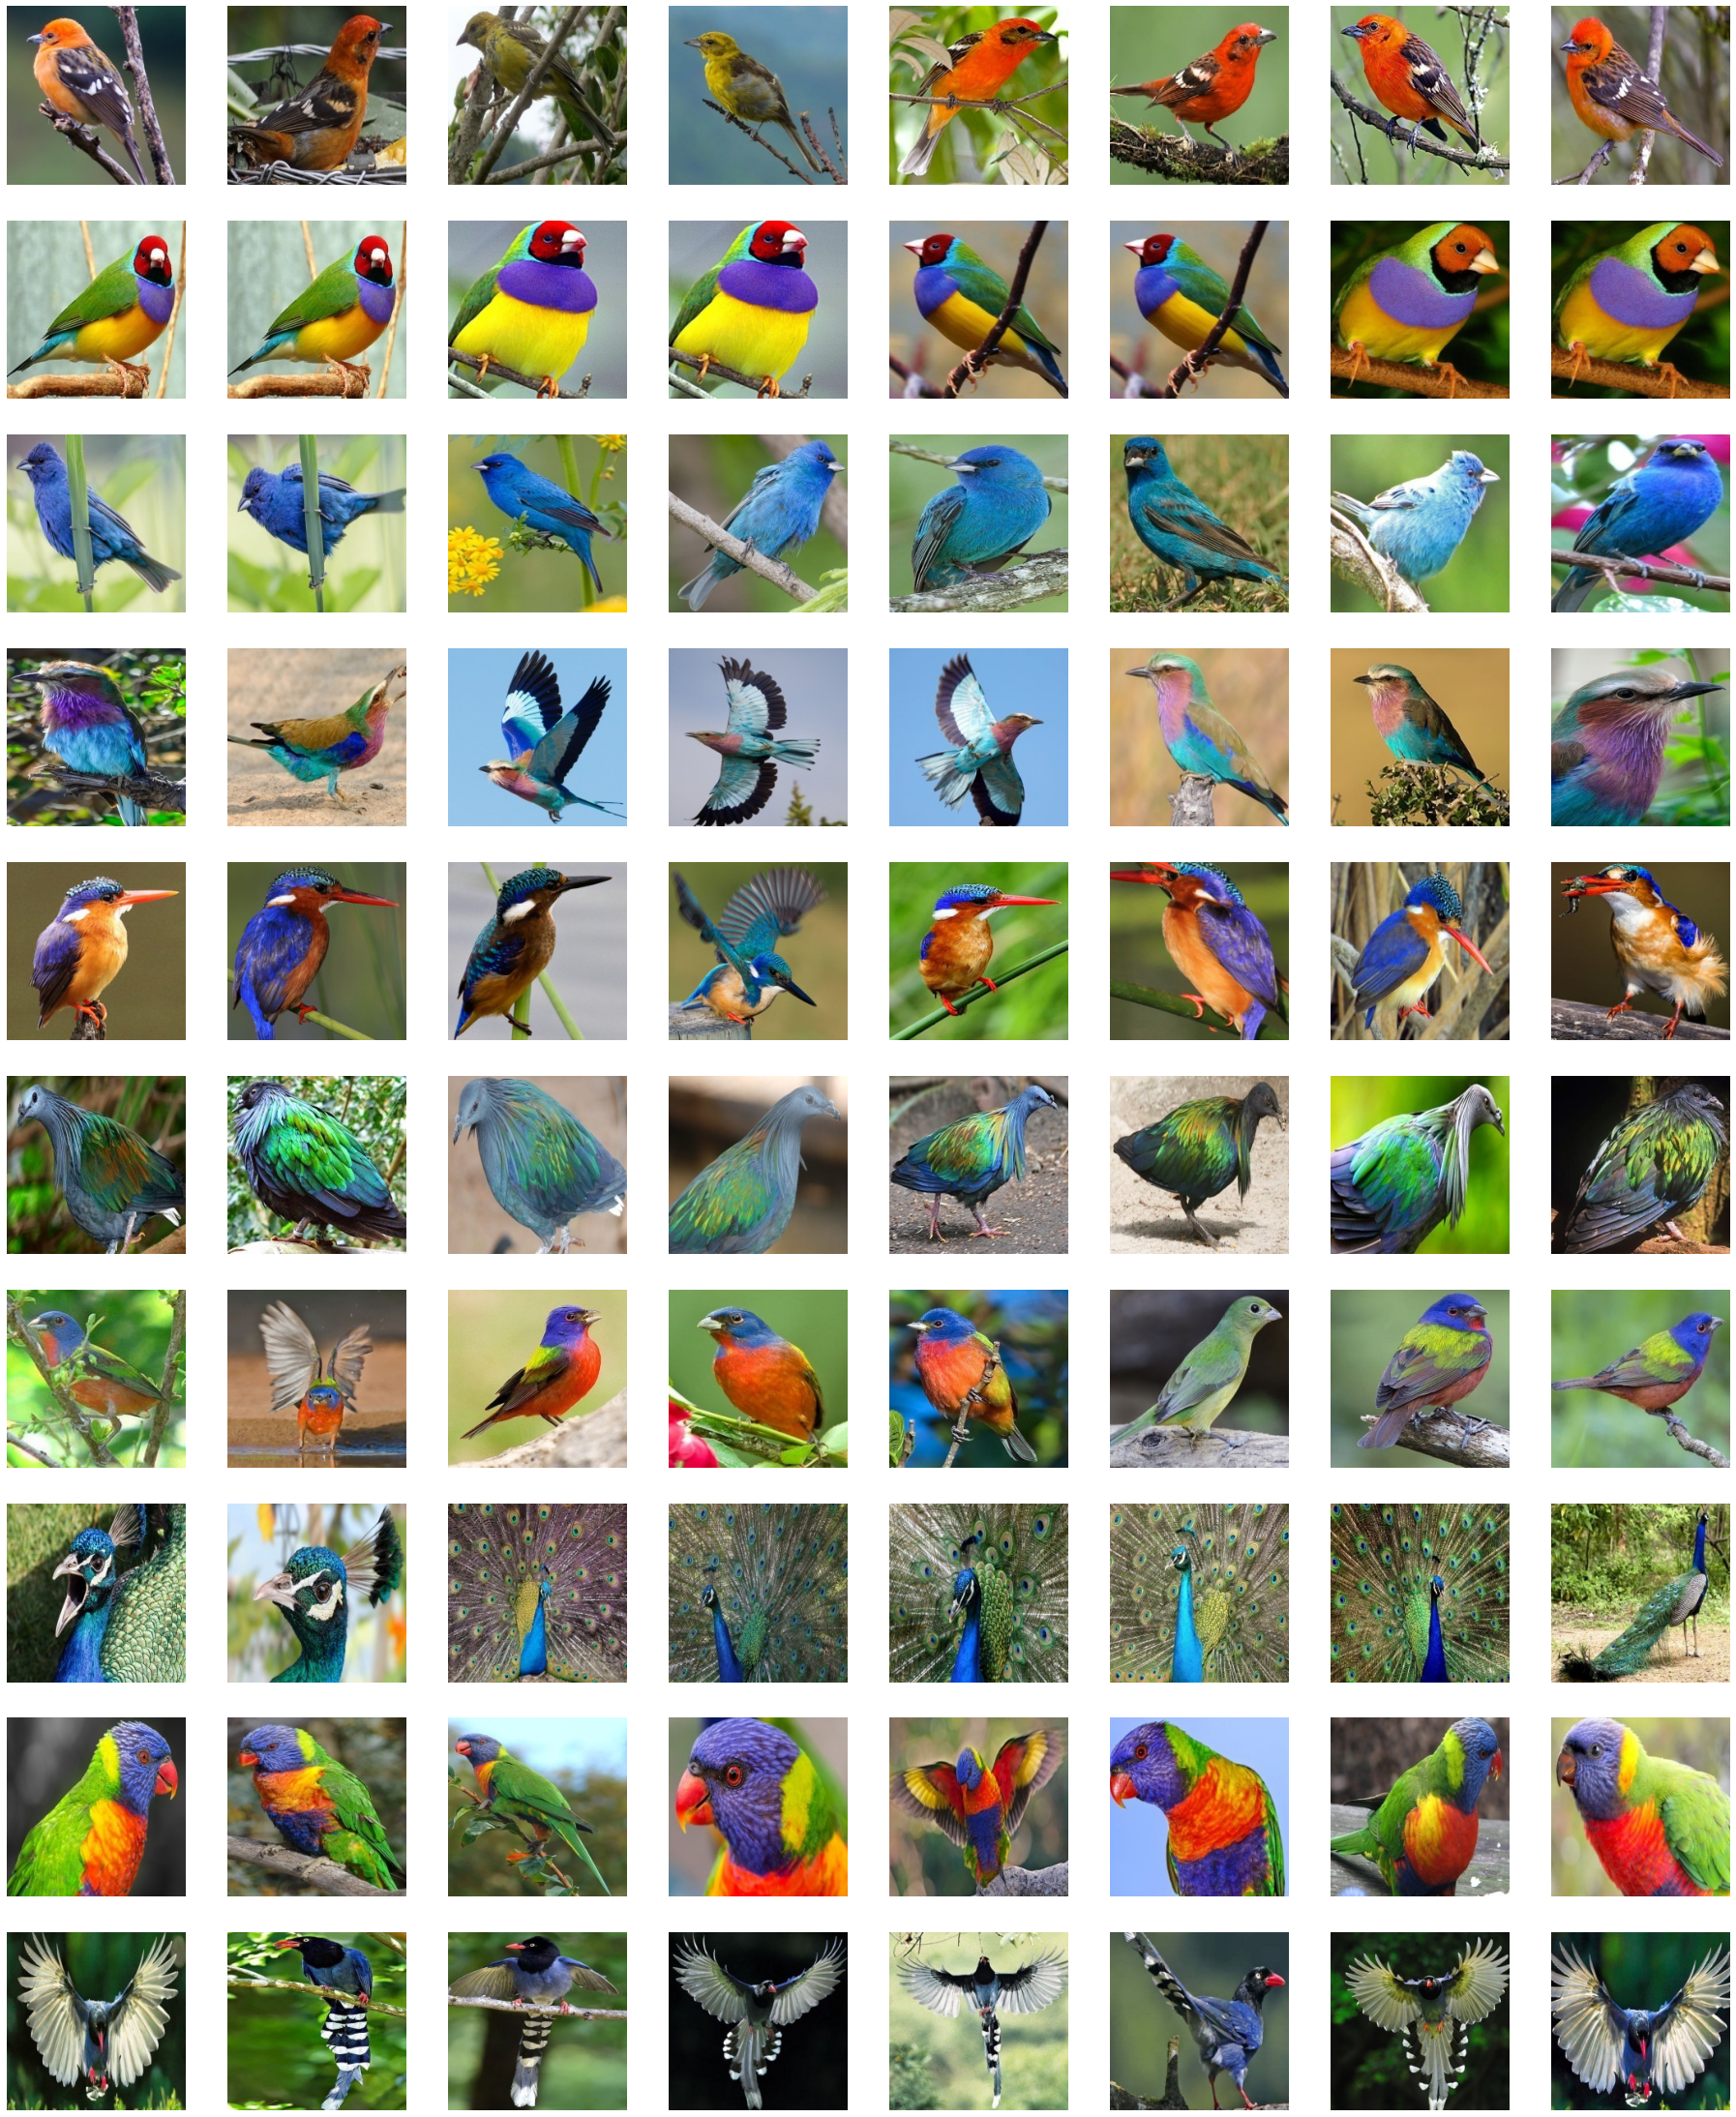

In [3]:
#a look at a few pictures to get a better sense of what the birds dataset look like

# configure the matplot parameters
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 10
ncols = 8
pic_index = 0  # Index for iterating over images
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index += 8

next_pix = [[os.path.join(trn_dirs[class_num], fname)
            for fname in trn_fnames[class_num][pic_index-8:pic_index]] for class_num in range(len(trn_dirs))]
next_pix = [each_bird for bird_dir in next_pix for each_bird in bird_dir]

for i, img_path in enumerate(next_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')  # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

def get_time_now():
    return datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/"

In [4]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_initializer='he_uniform', padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 300 neuron hidden layer
    tf.keras.layers.Dense(300, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['acc'])

log_dir_fit = log_dir + "fit/" + get_time_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_fit, histogram_freq=1)


In [5]:
img_width, img_height = 150, 150
# All images will be rescaled by 1./255.
trn_datagen = ImageDataGenerator(rescale=1.0/255.,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 horizontal_flip=True)
vldn_datagen = ImageDataGenerator(rescale=1.0/255.)

trn_gen = trn_datagen.flow_from_directory(trn_root_dir,
                                          batch_size=20,
                                          class_mode='binary',
                                          target_size=(img_width, img_height))

vldn_gen = vldn_datagen.flow_from_directory(vldn_root_dir,
                                            batch_size=20,
                                            class_mode='binary',
                                            target_size=(img_width, img_height))


Found 1160 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [6]:
history = model.fit(trn_gen,
                    validation_data=vldn_gen,
                    # steps_per_epoch=(len(trn_gen) // 20) + 1,
                    epochs=50,
                    validation_steps=(len(vldn_gen) // 20) + 1,
                    verbose=2,
                    callbacks=[tensorboard_callback])


Epoch 1/50
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
58/58 - 13s - loss: 2.0269 - acc: 0.2707 - val_loss: 1.3401 - val_acc: 0.5000
Epoch 2/50
58/58 - 13s - loss: 1.2022 - acc: 0.5862 - val_loss: 0.8101 - val_acc: 0.7500
Epoch 3/50
58/58 - 13s - loss: 0.8603 - acc: 0.7155 - val_loss: 0.6770 - val_acc: 0.7500
Epoch 4/50
58/58 - 13s - loss: 0.6491 - acc: 0.7810 - val_loss: 1.1773 - val_acc: 0.6000
Epoch 5/50
58/58 - 13s - loss: 0.5203 - acc: 0.8397 - val_loss: 0.3212 - val_acc: 0.8500
Epoch 6/50
58/58 - 13s - loss: 0.4610 - acc: 0.8569 - val_loss: 0.6156 - val_acc: 0.8500
Epoch 7/50
58/58 - 13s - loss: 0.4227 - acc: 0.8595 - val_loss: 0.8312 - val_acc: 0.7000
Epoch 8/50
58/58 - 13s - loss: 0.4040 - acc: 0.8716 - val_loss: 0.5154 - val_acc: 0.8500
Epoch 9/50
58/58 - 13s - loss: 0.3228 - acc: 0.8948 - val_loss: 0.5702 - val_acc: 0.9000
Epoch 10/50
58/58 - 13s - loss: 0.2383 - acc: 0.9233 - val_loss: 0.4318 - val_acc: 0.9000
Epoch 11/50
58/58 - 13s - loss: 0.216

In [7]:
from tensorflow.keras.preprocessing import image

test_imgs = [
    'Birds-Dataset/Validation/TAIWAN MAGPIE/001.jpg',
    'Birds-Dataset/Validation/PEACOCK/002.jpg',
    'Birds-Dataset/Validation/NICOBAR PIGEON/002.jpg'
]

imgs = [np.expand_dims(
            image.img_to_array(
                image.load_img(img, target_size=(img_width, img_height))
            ), axis=0) 
        for img in test_imgs]

# pass the list of multiple images np.vstack()
images = np.vstack(imgs)
classes = model.predict(images, batch_size=10)

# print the classes, the images belong to
all_classes = os.listdir(trn_root_dir)

class_names = [all_classes[int(np.where(np.isclose(predicted_class, 1))[0])]
               for predicted_class in classes]
print(class_names)
print(classes)

['TAIWAN MAGPIE', 'PEACOCK', 'NICOBAR PIGEON']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


Text(0.5, 1.0, 'Training and validation loss')

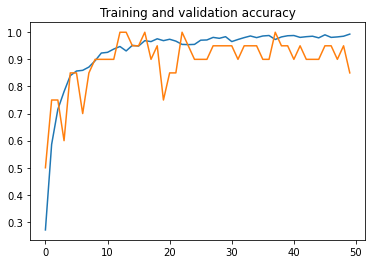

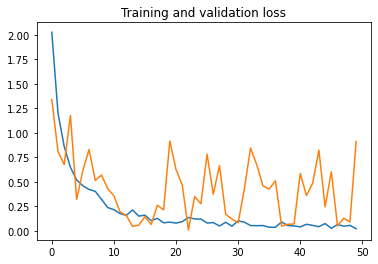

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))  # Get number of epochs

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [9]:
df = pd.DataFrame(columns=['img_names', 'labels', 'class_names'])

for i in range(len(trn_fnames)):
    class_name = all_classes[i]
    # print(class_name)
    for img_name in trn_fnames[i]:
        df = df.append({'img_names': os.path.join(trn_dirs[i], img_name), 'labels': i, 'class_names': class_name}, ignore_index=True)

df.to_csv('annotations.csv')

In [10]:
model_reduced = tf.keras.models.Sequential()
for layer in model.layers[:-1]:
    model_reduced.add(layer)

data = pd.read_csv('annotations.csv', usecols=['img_names', 'labels', 'class_names'])

def get_image_features(img_file):
    image = load_img(img_file, target_size=(img_width, img_height))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    features = model_reduced.predict(image)

    return features

img_feature_list = []

for img in tqdm.tqdm(data.img_names):
    img_features = get_image_features(img)
    img_feature_list.append(img_features)

img_features_arr = np.asarray(img_feature_list)
del img_feature_list
img_features_arr = np.rollaxis(img_features_arr, 1, 0)
img_features_arr = img_features_arr[0, :, :]
pickle.dump(img_features_arr, open('features.pkl', 'wb'))

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1160/1160 [00:57<00:00, 20.22it/s]


In [11]:
log_dir_embed = log_dir + 'embedding_logs'

if not os.path.exists(log_dir_embed):
    os.makedirs(log_dir_embed)
elif len(os.listdir(log_dir_embed)) > 0:
    for file in os.listdir(log_dir_embed):
        os.remove(os.path.join(log_dir_embed, file))

metadata_filename = 'metadata_classes.tsv'
metadata_file = open(os.path.join(log_dir_embed, metadata_filename), 'w')
metadata_file.write('Class\tName\n')

for label, name in zip(data.labels, data.class_names):
    metadata_file.write('{}\t{}\n'.format(label, name))
metadata_file.close()

img_data = []
for img in tqdm.tqdm(data.img_names):
    inp_img = cv2.imread(img)
    inp_img_small = cv2.resize(inp_img, (img_width, img_height))
    img_data.append(inp_img_small)
img_data = np.array(img_data)

def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

sprite_imgs = images_to_sprite(img_data)
sprite_filename = 'sprite_classes.png'
cv2.imwrite(os.path.join(log_dir_embed, sprite_filename), sprite_imgs)

pickle_file = 'features.pkl'
with open(pickle_file, 'rb') as f:
    feature_vectors = pickle.load(f)

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1160/1160 [00:01<00:00, 720.50it/s]


In [12]:
%load_ext tensorboard
features = tf.Variable(feature_vectors, name='features')

checkpoint = tf.train.Checkpoint(embedding=features)
checkpoint.save(os.path.join(log_dir_embed, 'embedding.ckpt'))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()

embedding.tensor_name = 'embedding/.ATTRIBUTES/VARIABLE_VALUE'
embedding.metadata_path = metadata_filename

embedding.sprite.image_path = sprite_filename
embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])

projector.visualize_embeddings(log_dir_embed, config)